In [1]:
# Burst Segmentation, UMAP & Feature Histograms 



# Import required libraries
import os                          # For file handling (listing files, paths)
import pyabf                       # Read ABF electrophysiology files (voltage recordings)
import numpy as np                 # Numeric computations
import pandas as pd                # DataFrames to store features
from scipy.stats import skew, kurtosis   # Statistical metrics for waveform analysis
from scipy.signal import find_peaks      # Detect voltage peaks (spikes)
from sklearn.preprocessing import StandardScaler   # Scale features before UMAP
import umap                        # Dimensionality reduction for visualization
import matplotlib.pyplot as plt    # Static plotting
import seaborn as sns              # Advanced plotting (histograms, scatterplots)
import plotly.express as px        # Interactive plots
import plotly.io as pio
import math                        # Math functions if needed

# Set Plotly renderer to open interactive plots in a browser

pio.renderers.default = "browser"

# Parameters for analysis
folder_path = "bursting"   # Folder containing ABF recordings
threshold = -35            # Voltage threshold (mV) for spike detection
burst_threshold = 0.3      # Max interval (s) between spikes to be part of same burst
fs = 10000                 # Sampling frequency (Hz)
dt = 1 / fs                # Sampling interval (s)



# Criteria for bursts
min_spikes_in_burst = 4    # Minimum number of spikes to qualify as a burst
max_isi = 0.3              # Maximum ISI inside bursts
min_spike_rate = 5         # Not used here, could filter bursts by spike rate

# List to store all computed metrics from each segment (burst or non-burst)
all_segment_metrics = []

# Load ABF files and analyze
# Find all .abf files in folder
abf_files = [f for f in os.listdir(folder_path) if f.endswith(".abf")]


# Loop through each ABF file
for file_name in abf_files:
    file_path = os.path.join(folder_path, file_name)
    abf = pyabf.ABF(file_path)   # Load the ABF file
    # Loop through all sweeps (epochs) in the ABF file

    for sweep in range(abf.sweepCount):
        abf.setSweep(sweep)        # Load specific sweep
        time = abf.sweepX          # Time array (seconds)
        voltage = abf.sweepY       # Voltage array (mV)

        # Spike detection
        # Detect voltage peaks above threshold
        peaks, _ = find_peaks(voltage, height=threshold)
        spike_times = peaks / fs   # Convert spike indices to seconds

        # Burst detection
        # Group spikes into bursts based on inter-spike intervals (ISI)
        bursts = []
        if len(spike_times) >= min_spikes_in_burst:
            isi = np.diff(spike_times)   # Time differences between spikes
            current_burst = [spike_times[0]]  # Start first burst
            for i in range(1, len(spike_times)):
                if isi[i - 1] < burst_threshold:
                    # Spike belongs to current burst
                    current_burst.append(spike_times[i])

                else:
                    # ISI too long, end of current burst
                    if len(current_burst) >= min_spikes_in_burst:
                        bursts.append((current_burst[0], current_burst[-1]))
                    current_burst = [spike_times[i]]  # Start new burst
            # Add final burst if valid
            if len(current_burst) >= min_spikes_in_burst:
                bursts.append((current_burst[0], current_burst[-1]))

        # Segment bursts and non-bursts
        segments = []
        for start, end in bursts:
            segments.append((start, end, "Burst"))  # Label detected bursts

        # Identify non-burst intervals
        if bursts:
            if bursts[0][0] > time[0]:
                segments.insert(0, (time[0], bursts[0][0], "Non-burst"))
            for i in range(len(bursts) - 1):
                segments.append((bursts[i][1], bursts[i + 1][0], "Non-burst"))
            if bursts[-1][1] < time[-1]:
                segments.append((bursts[-1][1], time[-1], "Non-burst"))

        else:
            # Entire sweep is non-burst
            segments.append((time[0], time[-1], "Non-burst"))

        # Classify burst waveform types

        burst_types = []
        for i, (seg_start, seg_end, seg_type) in enumerate(segments):
            if seg_type == "Burst":
                seg_mask = (time >= seg_start) & (time <= seg_end)
                seg_voltage = voltage[seg_mask]

                # Compute average voltage before and after the burst
                prev_mean = np.nan
                next_mean = np.nan
                if i > 0:
                    prev_end = segments[i - 1][1]
                    inter_mask_prev = (time > prev_end) & (time < seg_start)
                    if np.any(inter_mask_prev):

                        prev_mean = np.mean(voltage[inter_mask_prev])
                if i < len(segments) - 1:
                    next_start = segments[i + 1][0]
                    inter_mask_next = (time > seg_end) & (time < next_start)
                    if np.any(inter_mask_next):
                        next_mean = np.mean(voltage[inter_mask_next])

                inter_mean = np.nanmean([prev_mean, next_mean])  # Baseline around burst
                burst_min = np.min(seg_voltage)  # Lowest voltage in burst

                # Simple rule to classify burst waveform shape
                if np.isnan(inter_mean):
                    burst_type = "Other"
                elif burst_min > inter_mean:
                    burst_type = "Square Wave"
                elif burst_min < inter_mean:
                    burst_type = "Parabolic"
                else:
                    burst_type = "Other"
            else:
                burst_type = "Non-burst"
            burst_types.append(burst_type)

        # Feature extraction for each segment
        for j, (seg_start, seg_end, seg_type) in enumerate(segments):
            seg_mask = (time >= seg_start) & (time <= seg_end)
            seg_voltage = voltage[seg_mask]
            duration = seg_end - seg_start  # Segment duration in seconds
            burst_type = burst_types[j]

            # Count spikes within this segment
            seg_peaks, _ = find_peaks(seg_voltage, height=threshold)
            num_peaks = len(seg_peaks)

            fragment_stats = []
            if len(seg_voltage) > 0:
                n = len(seg_voltage)
                fragment_len = max(1, n // 10)  # Divide segment into 10 fragments
                for i in range(10):
                    start_idx = i * fragment_len
                    end_idx = (i + 1) * fragment_len if i < 9 else n
                    frag = seg_voltage[start_idx:end_idx]

                    # Compute 17 features per fragment
                    if len(frag) == 0:
                        frag_stats = [np.nan] * 17

                    else:
                        deriv_frag = np.diff(frag) / dt if len(frag) > 1 else np.array([0.0])
                        frag_stats = [
                            np.mean(frag), np.std(frag), np.min(frag), np.max(frag),
                            skew(frag) if len(frag) > 2 else 0.0,
                            kurtosis(frag) if len(frag) > 3 else 0.0,
                            np.trapz(frag, dx=dt),                     # Area under curve
                            np.mean(deriv_frag), np.std(deriv_frag),
                            np.min(deriv_frag), np.max(deriv_frag),
                            skew(deriv_frag) if len(deriv_frag) > 2 else 0.0,
                            kurtosis(deriv_frag) if len(deriv_frag) > 3 else 0.0,
                            np.percentile(frag, 25),
                            np.percentile(frag, 50),
                            np.percentile(frag, 75),
                            np.percentile(frag, 95)
                        ]

                    fragment_stats.extend(frag_stats)

            else:
                # Segment has no data, fill with NaNs
                fragment_stats = [np.nan] * 170 # Hopefully the data frame has no missing values

            # Store features for this segment (file, sweep, segment info, stats)
            all_segment_metrics.append([file_name, sweep, seg_type, burst_type, duration, num_peaks] + fragment_stats)

# Save computed features to CSV
base_cols = ["File_Name", "Sweep", "Segment_Type", "Burst_Type", "Duration", "Num_Peaks"]


# Create column names for 10 fragments × 17 features
frag_cols = []
for i in range(1, 11):
    frag_cols += [
        f"Mean_{i}", f"Std_{i}", f"Min_{i}", f"Max_{i}",
        f"Skewness_{i}", f"Kurtosis_{i}", f"Area_{i}",
        f"Mean_Deriv_{i}", f"Std_Deriv_{i}", f"Min_Deriv_{i}",
        f"Max_Deriv_{i}", f"Skewness_Deriv_{i}", f"Kurtosis_Deriv_{i}",
        f"Q25_{i}", f"Q50_{i}", f"Q75_{i}", f"Q95_{i}"
    ]


# Create DataFrame and save CSV
df_segments = pd.DataFrame(all_segment_metrics, columns=base_cols + frag_cols)
csv_filename = "segment_voltage_metrics_fragments_with_quartiles1.csv"
df_segments.to_csv(csv_filename, index=False)
print(f"File saved: {csv_filename}")

# Dimensionality reduction using UMAP
df = pd.read_csv(csv_filename)
X = np.array(df[frag_cols], dtype=float)  # Feature matrix
y = np.array(df.Burst_Type)               # Labels for coloring

# Replace NaNs with 0 and scale features
X[np.isnan(X)] = 0
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply UMAP to reduce 170D features 2D
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# Save UMAP coordinates + burst labels
df_umap = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
df_umap["Burst_Type"] = y
df_umap.to_csv("umap_coordinates_segments.csv", index=False)
print("UMAP coordinates saved: umap_coordinates_segments.csv")

# Visualization: Static UMAP (Seaborn)
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", hue="Burst_Type", palette="tab10", alpha=0.8)
plt.title("UMAP of Segment Fragments (Burst + Non-burst)")
plt.tight_layout()
plt.show()


# Histogram: segment durations
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="Duration", hue="Burst_Type", bins=30, kde=True, palette="tab10", alpha=0.6)
plt.title("Distribution of Segment Duration")
plt.tight_layout()
plt.show()

# Interactive 2D UMAP (Plotly)
fig = px.scatter(df_umap, x="UMAP1", y="UMAP2", color="Burst_Type", title="UMAP Projection")
pio.renderers.default = "browser"
fig.show()

# Aggregated histograms for each feature base
feature_bases = [
    "Mean", "Std", "Min", "Max", "Skewness", "Kurtosis", "Area",
    "Mean_Deriv", "Std_Deriv", "Min_Deriv", "Max_Deriv",
    "Skewness_Deriv", "Kurtosis_Deriv",
    "Q25", "Q50", "Q75", "Q95"
]

sns.set(style="whitegrid", context="notebook")
ncols = 4
nrows = int(np.ceil(len(feature_bases) / ncols))
plt.figure(figsize=(20, nrows * 3))

# Loop over feature categories and plot histograms for each burst type
for i, base in enumerate(feature_bases, 1):
    plt.subplot(nrows, ncols, i)
    cols = [f"{base}_{j}" for j in range(1, 11) if f"{base}_{j}" in df.columns]
    # Combine fragment values across each burst type
    for burst_type in df["Burst_Type"].unique():
        subset = df[df["Burst_Type"] == burst_type][cols].values.flatten()
        sns.histplot(subset, bins=50, kde=True, label=burst_type, alpha=0.5)

    plt.title(base)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.legend()

plt.tight_layout()
plt.suptitle("Distribution of aggregated features by burst type", fontsize=18, y=1.02)
plt.show()

FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: 'bursting'

Base model accuracy: 0.9989484752891693
Group importances: {'Std': np.float64(0.2937960042060988), 'Std_Deriv': np.float64(0.09442691903259728), 'Max': np.float64(0.014090431125131465), 'Max_Deriv': np.float64(0.008201892744479532), 'Skewness': np.float64(0.006940063091482651), 'Kurtosis_Deriv': np.float64(0.005888538380651931), 'Kurtosis': np.float64(0.0052576235541535125), 'Min': np.float64(0.003995793901156652), 'Skewness_Deriv': np.float64(0.0033648790746582335), 'Mean': np.float64(0.0029442691903259544), 'Mean_Deriv': np.float64(0.002523659305993675), 'Min_Deriv': np.float64(0.0018927444794952565), 'Area': np.float64(0.0016824395373291167), 'Q95': np.float64(0.0016824395373291167), 'Q75': np.float64(0.0014721345951629772), 'Q25': np.float64(0.001051524710830698), 'Q50': np.float64(0.001051524710830698)}


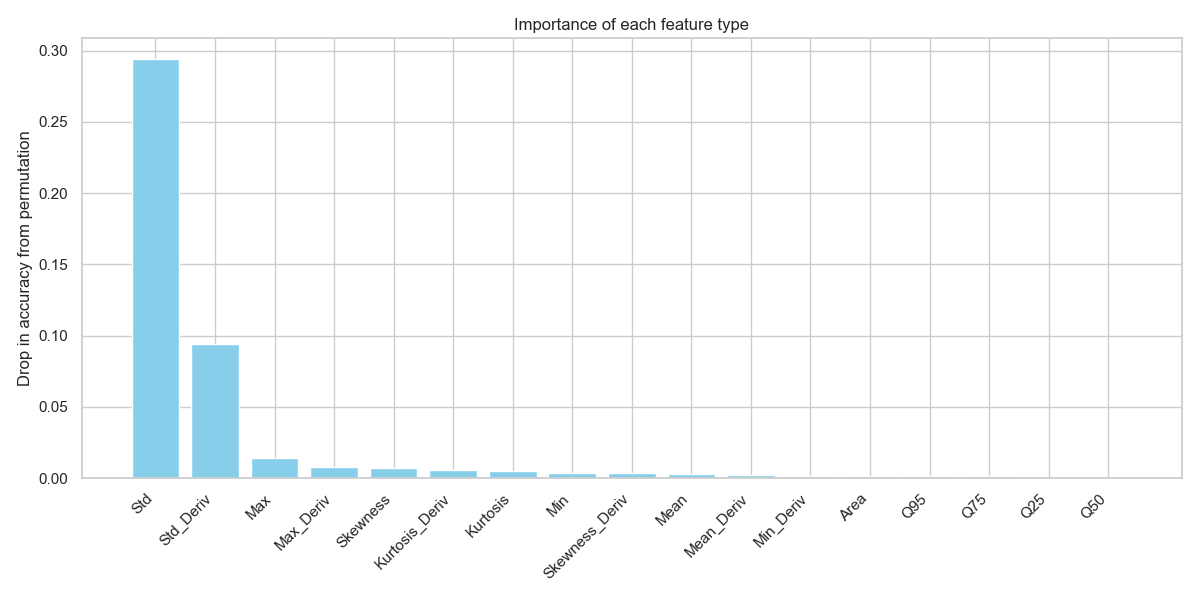

Mean            Accuracy: 0.9979 | Drop: 0.0011
Std             Accuracy: 0.9968 | Drop: 0.0021
Min             Accuracy: 0.9989 | Drop: 0.0000
Max             Accuracy: 0.9979 | Drop: 0.0011
Skewness        Accuracy: 0.9989 | Drop: 0.0000
Kurtosis        Accuracy: 0.9979 | Drop: 0.0011
Area            Accuracy: 0.9989 | Drop: 0.0000
Mean_Deriv      Accuracy: 0.9989 | Drop: 0.0000
Std_Deriv       Accuracy: 0.9979 | Drop: 0.0011
Min_Deriv       Accuracy: 0.9989 | Drop: 0.0000
Max_Deriv       Accuracy: 0.9989 | Drop: 0.0000
Skewness_Deriv  Accuracy: 0.9989 | Drop: 0.0000
Kurtosis_Deriv  Accuracy: 0.9979 | Drop: 0.0011
Q25             Accuracy: 0.9989 | Drop: 0.0000
Q50             Accuracy: 0.9989 | Drop: 0.0000
Q75             Accuracy: 0.9989 | Drop: 0.0000
Q95             Accuracy: 0.9979 | Drop: 0.0011

 Drop in accuracy by group (sorted):
Std             Accuracy = 0.0021
Mean            Accuracy = 0.0011
Max             Accuracy = 0.0011
Kurtosis        Accuracy = 0.0011
Std_Deriv 

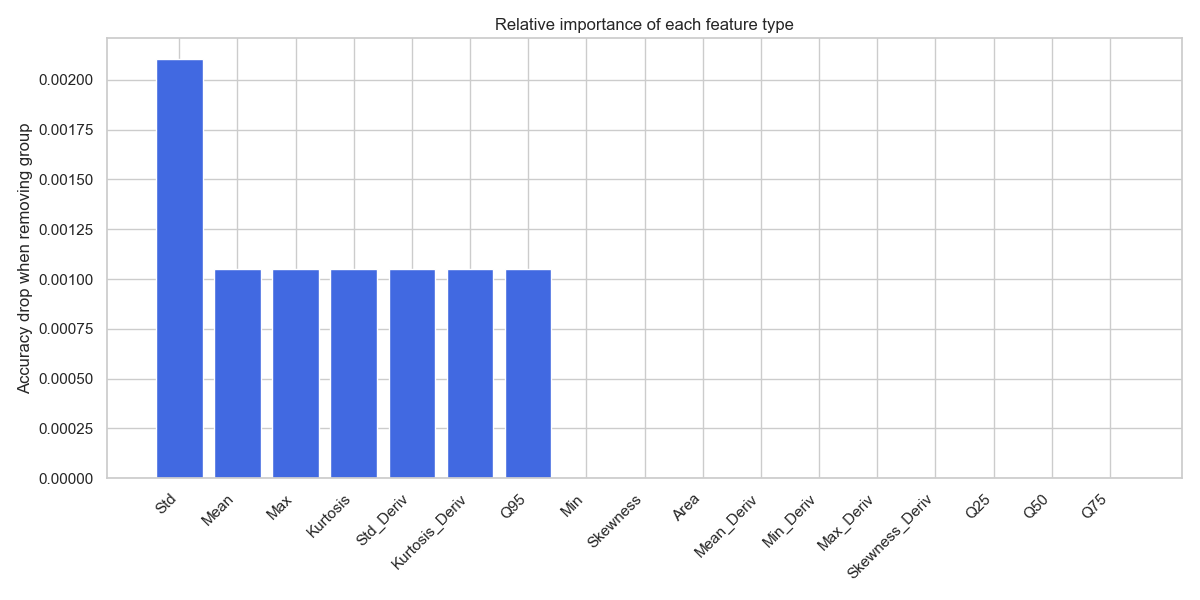

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder # Converts categorical labels (e.g., burst types) into numeric integers
from sklearn.ensemble import RandomForestClassifier # Ensemble of decision trees used for classification tasks
import matplotlib.pyplot as plt

# Load dataset
# Load the CSV file containing all segment features computed from bursts/non-bursts
df = pd.read_csv('segment_voltage_metrics_fragments_with_quartiles1.csv')

# Prepare target variable
# Burst_Type is categorical; we convert it to numeric labels
le = LabelEncoder()
y = le.fit_transform(df['Burst_Type'])  # 0 (Non-burst),1,2 and 3(Square wave) integers representing each burst type. 1 and 2 are Parabolic and Other, but I don't know which of them is 1 or 2

# Define feature groups
# The 170 fragment features are organized into logical groups
feature_types = [
    'Mean', 'Std', 'Min', 'Max', 'Skewness', 'Kurtosis',
    'Area', 'Mean_Deriv', 'Std_Deriv', 'Min_Deriv', 'Max_Deriv',
    'Skewness_Deriv', 'Kurtosis_Deriv', 'Q25', 'Q50', 'Q75', 'Q95'
]


groups = {}
for ft in feature_types:
    # Collect all columns starting with the feature type prefix (e.g., "Mean_1".."Mean_10")
    cols = [col for col in df.columns if col.startswith(ft + '_')]
    if cols:
        groups[ft] = cols  # Store in dictionary: group name, list of columns

# Create full feature matrix
# Flatten all group columns into a single list
all_cols = [col for cols in groups.values() for col in cols]
X = df[all_cols]  # Feature matrix for model training

# Train Random Forest model
# Random Forest classifier with 20 trees
model = RandomForestClassifier(n_estimators=20, random_state=42)
model.fit(X, y)  # Train model on all features
base_score = model.score(X, y)  # Accuracy on training data
print("Base model accuracy:", base_score)

# Permutation importance function
def group_permutation_importance(model, X, y, group_cols, n_iter=5):
    #Compute the average drop in model accuracy when a feature group is permuted. Higher drop more important group.
    drops = []
    for _ in range(n_iter):
        X_permuted = X.copy()  # Make a copy to avoid modifying original
        # Shuffle values of the feature group across samples
        X_permuted[group_cols] = X_permuted[group_cols].sample(frac=1).to_numpy()
        score = model.score(X_permuted, y)  # Accuracy with shuffled group
        drops.append(base_score - score)    # Drop in performance
    return np.mean(drops)  # Average over iterations

# Compute permutation importance for each group
group_importances = {
    name: group_permutation_importance(model, X, y, cols)
    for name, cols in groups.items()
}


# Sort by descending importance
group_importances = dict(sorted(group_importances.items(), key=lambda x: x[1], reverse=True))
print("Group importances:", group_importances)

# Visualize permutation importance
plt.figure(figsize=(12,6))
plt.bar(group_importances.keys(), group_importances.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.ylabel("Drop in accuracy from permutation")
plt.title("Importance of each feature type")
plt.tight_layout()
plt.show()

# Alternative: drop-group importance (retrain without group)
group_drops = {}
for name, cols in groups.items():
    X_no_group = X.drop(columns=cols)  # Remove current group
    model_tmp = RandomForestClassifier(n_estimators=20, random_state=42)
    model_tmp.fit(X_no_group, y)       # Retrain without this group
    score = model_tmp.score(X_no_group, y)  # Accuracy without group
    drop = base_score - score          # Drop in accuracy
    group_drops[name] = drop
    print(f"{name:15s} Accuracy: {score:.4f} | Drop: {drop:.4f}")

# Sort drops to rank feature groups by importance
group_drops = dict(sorted(group_drops.items(), key=lambda x: x[1], reverse=True))
print("\n Drop in accuracy by group (sorted):")

for name, drop in group_drops.items():
    print(f"{name:15s} Accuracy = {drop:.4f}")

# Visualize drop-group importance
plt.figure(figsize=(12,6))
plt.bar(group_drops.keys(), group_drops.values(), color='royalblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Accuracy drop when removing group")
plt.title("Relative importance of each feature type")
plt.tight_layout()
plt.show()

c:\Users\manur\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



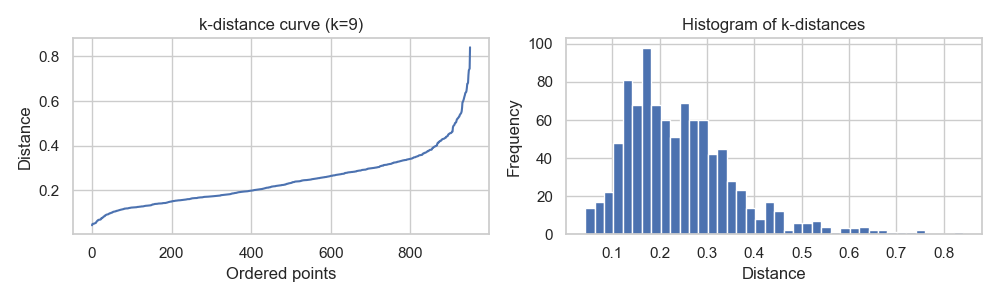

Candidate eps values:
  0.3012
  0.3236
  0.3453
  0.3728
  0.3880
  0.4567
  0.5965
  0.7457
  0.8948
  1.1185

Results for candidate eps values:
     eps  n_clusters  n_noise  pct_noise  silhouette
0.301198          34      129  13.564669    0.400582
0.323627          32       83   8.727655    0.453534
0.345348          27       63   6.624606    0.434925
0.372829          22       34   3.575184    0.492224
0.387997          20       33   3.470032    0.514131
0.456739          15       11   1.156677    0.441374
0.596527          10        0   0.000000    0.219740
0.745659           5        0   0.000000    0.394279
0.894791           3        0   0.000000    0.203357
1.118488           3        0   0.000000    0.203357


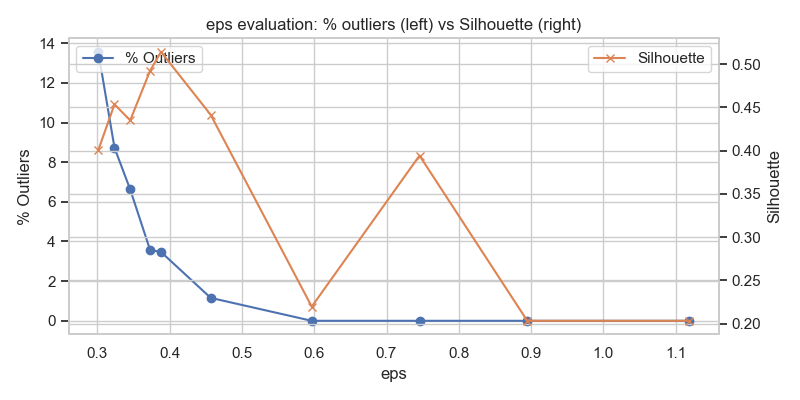


Automatically selected eps: 0.3880  (maximum silhouette (0.514))
Final DBSCAN: 20 clusters, 33 outliers (3.47%)
LOF detected outliers: 35 (3.68%)
Consensus outliers (DBSCAN ∪ LOF): 61 (6.41%)


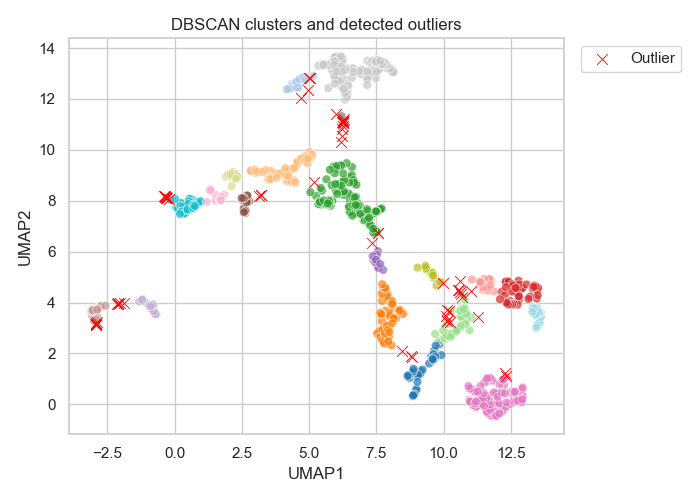

Saved: 'outliers_consensus_DBSCAN_LOF.csv' and 'UMAP_with_DBSCAN_and_Outliers.csv'


In [ ]:
# CLUSTERING AND OUTLIER DETECTION (DBSCAN + LOF)
import pandas as pd                      # Data manipulation and analysis (tables, CSVs, DataFrames)
import numpy as np                       # Numerical computing, arrays, mathematical operations
import seaborn as sns                     # Statistical data visualization built on Matplotlib
import matplotlib.pyplot as plt           # Core plotting library for creating charts and figures
from sklearn.preprocessing import StandardScaler  # Standardize features by removing mean and scaling to unit variance
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor  # NN: find nearest neighbors; LOF: detect outliers
from sklearn.cluster import DBSCAN        # Density-based clustering algorithm
from sklearn.metrics import silhouette_score  # Evaluate quality of clustering
import umap                               # Dimensionality reduction algorithm for visualization and embedding
%matplotlib widget

sns.set(style="whitegrid", context="notebook")
# Load CSV with reduced features and generate UMAP embedding
df = pd.read_csv("segment_voltage_metrics_fragments_with_quartiles1.csv")
# Keep only numerical feature columns (remove metadata and labels)
feature_cols = [c for c in df.columns if c not in 
    ["File_Name", "Sweep", "Segment_Type", "Burst_Type", "Duration", "Num_Peaks"]]
# Scale the features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[feature_cols].fillna(0))

# Compute a 2D UMAP embedding to visualize and cluster
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# Create dataframe with UMAP coordinates and labels
df_umap = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
df_umap["Burst_Type"] = df["Burst_Type"]
# k-distance analysis to estimate eps for DBSCAN
min_samples = 10
k = min_samples - 1

# Compute distances to the k nearest neighbors
nn = NearestNeighbors(n_neighbors=k)
nn.fit(embedding)
distances, _ = nn.kneighbors(embedding)
k_distances = np.sort(distances[:, -1])


# Plot the k-distance curve to find an elbow (suggested eps)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(k_distances)
axes[0].set_title(f"k-distance curve (k={k})")
axes[0].set_xlabel("Ordered points")
axes[0].set_ylabel("Distance")
axes[1].hist(k_distances, bins=40)
axes[1].set_title("Histogram of k-distances")
axes[1].set_xlabel("Distance")
axes[1].set_ylabel("Frequency")
plt.tight_layout()
plt.show()


# Generate candidate eps values
# Detect largest distance jump (potential knee point)
diffs = np.diff(k_distances)
eps_jump = float(k_distances[np.argmax(diffs)])


# Compute percentile-based and multiplier-based eps values
percentiles = [75, 80, 85, 90, 95]
eps_percentiles = [float(np.percentile(k_distances, p)) for p in percentiles]
multipliers = [0.5, 0.8, 1.0, 1.2, 1.5]
eps_multipliers = [eps_jump * m for m in multipliers]


# Combine all candidates into one sorted list
eps_candidates = sorted(set([eps_jump] + eps_percentiles + eps_multipliers))
print("Candidate eps values:")

for e in eps_candidates:
    print(f"  {e:.4f}")

# Try DBSCAN with each eps and evaluate clustering quality
results = []

for eps in eps_candidates:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(embedding)
    # Compute number of outliers (noise) and clusters
    n_noise = int((labels == -1).sum())
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    pct_noise = 100 * n_noise / len(labels)
    # Compute silhouette score only if >1 cluster exists
    sil = np.nan

    if n_clusters > 1:
        try:
            sil = silhouette_score(embedding, labels)
        except Exception:
            sil = np.nan


    results.append({
        "eps": eps, "n_clusters": n_clusters, "n_noise": n_noise,
        "pct_noise": pct_noise, "silhouette": sil
    })



# Create summary DataFrame with all eps evaluations
df_eps = pd.DataFrame(results).sort_values("eps")
print("\nResults for candidate eps values:")
print(df_eps.to_string(index=False))


# Plot eps performance (outliers vs silhouette)
fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()
ax1.plot(df_eps['eps'], df_eps['pct_noise'], marker='o', label='% Outliers')
ax2.plot(df_eps['eps'], df_eps['silhouette'], marker='x', color='C1', label='Silhouette')
ax1.set_xlabel('eps')
ax1.set_ylabel('% Outliers')
ax2.set_ylabel('Silhouette')
ax1.set_title('eps evaluation: % outliers (left) vs Silhouette (right)')
ax1.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()


# Automatic selection of best eps
valid_sil = df_eps.dropna(subset=['silhouette'])
# Prefer eps with highest silhouette score (best clustering quality)
if not valid_sil.empty:
    best_row = valid_sil.loc[valid_sil['silhouette'].idxmax()]
    eps_selected = float(best_row['eps'])
    reason = f"maximum silhouette ({best_row['silhouette']:.3f})"

else:
    # Otherwise, use eps where % outliers is between 1–10%
    candidates_pct = df_eps[(df_eps['pct_noise'] >= 1) & (df_eps['pct_noise'] <= 10)]
    if not candidates_pct.empty:
        eps_selected = float(candidates_pct.iloc[0]['eps'])
        reason = "pct_noise between 1% and 10%"

    else:
        # Fallback: use 90th percentile of k-distances
        eps_selected = float(np.percentile(k_distances, 90))
        reason = "90th percentile fallback"
print(f"\nAutomatically selected eps: {eps_selected:.4f}  ({reason})")


# Final DBSCAN run
db_final = DBSCAN(eps=eps_selected, min_samples=min_samples)
labels_final = db_final.fit_predict(embedding)
df_umap["DBSCAN_Label"] = labels_final


# Compute final cluster and outlier statistics
n_noise = (labels_final == -1).sum()
n_clusters = len(set(labels_final)) - (1 if -1 in labels_final else 0)
pct_noise = 100 * n_noise / len(labels_final)
print(f"Final DBSCAN: {n_clusters} clusters, {n_noise} outliers ({pct_noise:.2f}%)")

# Local Outlier Factor (LOF) outlier detection
# LOF estimates how isolated a point is from its neighbors
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
lof_labels = lof.fit_predict(embedding)
df_umap["LOF_Label"] = lof_labels
lof_outliers = (lof_labels == -1)
print(f"LOF detected outliers: {lof_outliers.sum()} ({100*lof_outliers.sum()/len(df_umap):.2f}%)")


# Outlier consensus (DBSCAN ∪ LOF)
# Combine both outlier detection methods:
#   - DBSCAN: points labeled -1
#   - LOF: points labeled -1
df_umap["Outlier_DBSCAN"] = df_umap["DBSCAN_Label"] == -1
df_umap["Outlier_LOF"] = df_umap["LOF_Label"] == -1
df_umap["Outlier_Consensus"] = df_umap["Outlier_DBSCAN"] | df_umap["Outlier_LOF"]
n_outliers_cons = df_umap["Outlier_Consensus"].sum()
print(f"Consensus outliers (DBSCAN ∪ LOF): {n_outliers_cons} ({100*n_outliers_cons/len(df_umap):.2f}%)")


# Compact visualization of clusters and outliers
plt.figure(figsize=(7, 5))
# Normal points (colored by DBSCAN cluster)
sns.scatterplot(
    data=df_umap[df_umap["Outlier_Consensus"] == False],
    x="UMAP1", y="UMAP2", hue="DBSCAN_Label",
    palette="tab20", s=40, alpha=0.7, legend=False
)


# Outliers (marked in red)
sns.scatterplot(
    data=df_umap[df_umap["Outlier_Consensus"] == True],
    x="UMAP1", y="UMAP2", color="red", marker="x", s=60, label="Outlier"
)

plt.title("DBSCAN clusters and detected outliers")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Save results
# Save both the consensus outliers and the full dataset with cluster labels
outliers_df = df_umap[df_umap["Outlier_Consensus"]].copy()
outliers_df.to_csv("outliers_consensus_DBSCAN_LOF.csv", index=False)
df_umap.to_csv("UMAP_with_DBSCAN_and_Outliers.csv", index=False)
print("Saved: 'outliers_consensus_DBSCAN_LOF.csv' and 'UMAP_with_DBSCAN_and_Outliers.csv'")